In [1]:
# Imports 
import pandas as pd
from ast import literal_eval
import numpy as np
import os 
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk')
from enzymetk.sequence_search_blast import BLAST
from enzymetk.similarity_foldseek_step import FoldSeek
from enzymetk.similarity_reaction_step import ReactionDist
from enzymetk.save_step import Save
import pandas as pd
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

## First build the training sets
from sciutil import SciUtil
from rdkit import Chem, DataStructs
from rdkit.Chem import rdChemReactions
from sklearn.metrics.pairwise import cosine_similarity


def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax

# Just look at the reviewed section of UniProt

In [2]:
protein_natural_df = pd.read_pickle('output/esm3_embeddings.pkl') #output/uniprotkb_reviewed_true_2025_17_02_ESM_3B_complete.pkl')
protein_natural_df

,Unnamed: 0,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Organism (ID),Taxonomic lineage (Ids),...,Residue_1index,active_site_residue_counts,active_encodings,Polarity,temperature,temp_level,cofactor,cofactor_encodings,embedding,esm3_mean
0,1.0,A0A023I7E1,reviewed,ENG1_RHIMI,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",ENG1 LAM81A,Rhizomucor miehei,796,4839,"131567 (no rank), 2759 (superkingdom), 33154 (...",...,500|578|582,3,[0. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.666667,36.0,genus,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.0038913805, 0.054855403, -0.052346736, 0.0...","[-39.737057, -21.73464, 115.61881, -24.6642, 6..."
1,3.0,A0A024RXP8,reviewed,GUX1_HYPJR,"Exoglucanase 1 (EC 3.2.1.91) (1,4-beta-cellobi...",cbh1 M419DRAFT_125125,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,514,1344414,"131567 (no rank), 2759 (superkingdom), 33154 (...",...,229|234,2,[0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1.000000,24.0,species,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.061283756, 0.03423623, -0.034157578, -0.10...","[-7.6626697, -51.761505, -7.6263323, -25.13656..."
2,5.0,A0A024SH76,reviewed,GUX2_HYPJR,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",cbh2 M419DRAFT_122470,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,471,1344414,"131567 (no rank), 2759 (superkingdom), 33154 (...",...,245,1,[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.000000,24.0,species,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.024468612, 0.005739282, -0.05029483, -0.10...","[-84.30662, 13.718188, 38.682743, -37.19589, 4..."
3,7.0,A0A044RE18,reviewed,BLI_ONCVO,Endoprotease bli (EC 3.4.21.75) (Blisterase),Bli,Onchocerca volvulus,693,6282,"131567 (no rank), 2759 (superkingdom), 33154 (...",...,201|240|414,3,[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. ...,0.333333,NaN,NaN,['Ca(2+)'],[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.029328233, -0.011474491, 0.028238649, -0.0...","[-52.99865, 0.30193344, -54.392796, 40.890602,..."
4,11.0,A0A061I403,reviewed,FICD_CRIGR,Protein adenylyltransferase FICD (EC 2.7.7.108...,FICD HYPE H671_4g11989 I79_014982,Cricetulus griseus (Chinese hamster) (Cricetul...,455,10029,"131567 (no rank), 2759 (superkingdom), 33154 (...",...,360,1,[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.000000,NaN,NaN,"['Mg(2+)', 'Mn(2+)']",[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. ...,"[-0.0071850866, -0.012335801, 0.041346848, -0....","[-15.113102, -89.59905, 39.90594, -18.289934, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572211,NaN,Q9RS06,reviewed,Y2321_DEIRA,Putative esterase DR_2321 (EC 3.1.2.-),DR_2321,Deinococcus radiodurans (strain ATCC 13939 / D...,146,243230,"131567 (no rank), 2 (superkingdom), 1297 (phyl...",...,None,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,30.0,species,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0023719773, -0.0072611473, -0.010587693, -0...","[-70.25, 90.0266, 29.309967, 28.660473, 82.409..."
572617,NaN,Q9Y9P1,reviewed,3MGH_AERPE,Putative 3-methyladenine DNA glycosylase (EC 3...,APE_2247,Aeropyrum pernix (strain ATCC 700893 / DSM 118...,194,272557,"131567 (no rank), 2157 (superkingdom), 1783275...",...,None,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,90.0,species,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.09044339, -0.008577277, -0.00920795, 0.032...","[0.5398597, -78.83418, 38.98884, 1.3743622, -1..."
572786,NaN,Q9ZD84,reviewed,Y459_RICPR,Putative methyltransferase RP459 (EC 2.1.1.-),RP459,Rickettsia prowazekii (strain Madrid E),226,272947,"131567 (no rank), 2 (superkingdom), 1224 (phyl...",...,None,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,30.0,genus,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.011736228, -0.02944174, 0.07091671, -0.055...","[83.958336, 11.854852, -9.398917, 41.09485, 77..."
572797,NaN,Q9ZDD5,reviewed,Y396_RICPR,Putative dio

In [4]:
protein_ded_df = pd.read_pickle('output/protein-evolution-database_V4_proteins_reactions_clean_unique_variants.pkl')
protein_ded_df.columns

Index(['culture_collection_entry', 'enzyme_name_from_paper',
       'Uniprot_ID(if applicable)', 'comment', 'reaction_smiles',
       'parent_DNA_sequence', 'parent_aminoacid_sequence',
       'aminoacid_mutations_from_parent', 'variant_DNA_sequence',
       'mutations_from_parent', 'cofactor', 'additive (if applicable)',
       'additive_CAS', 'enzyme_form', 'substrate_concentration',
       'activity_for_reaction_% (if applicable)', 'TTN (if applicable)',
       'selectivity(ee%),diastereo or chemo should be a separate smiles entry',
       'alternative_product_SMILES', 'failed_substrates (if available)',
       'date published ', 'first author', 'paper title', 'doi', 'SUBMITTED BY',
       'raw data name', 'cannonical_reactions', 'named_reactions', 'errors',
       'parent_aa', 'variant_aa', 'warnings', 'id', 'variant_id',
       'variant_aa_nohis', 'esm3_mean'],
      dtype='object')

In [5]:
protein_ded_df['Entry'] = protein_ded_df['id'].values
protein_ded_df['Sequence'] = protein_ded_df['variant_aa'].values


In [6]:
protein_natural_df['label'] = 'reference'
protein_ded_df['label'] = 'query'

df = pd.concat([protein_natural_df, protein_ded_df])
id_col = 'Entry'
seq_col = 'Sequence'
label_col = 'label'

# Now we want to run BLAST to find the most similar sequences to the training dataset
df = df << (BLAST(id_col, seq_col, label_col) >> Save(f'output/DEDBase_BLAST_SwissProt.pkl'))

     Unnamed: 0     Entry Reviewed Entry Name Protein names Gene Names  \
0           NaN     DEDB0      NaN        NaN           NaN        NaN   
1           NaN     DEDB1      NaN        NaN           NaN        NaN   
2           NaN     DEDB2      NaN        NaN           NaN        NaN   
3           NaN     DEDB3      NaN        NaN           NaN        NaN   
4           NaN     DEDB4      NaN        NaN           NaN        NaN   
..          ...       ...      ...        ...           ...        ...   
362         NaN  DEDB1336      NaN        NaN           NaN        NaN   
363         NaN  DEDB1337      NaN        NaN           NaN        NaN   
364         NaN  DEDB1338      NaN        NaN           NaN        NaN   
365         NaN  DEDB1339      NaN        NaN           NaN        NaN   
366         NaN  DEDB1340      NaN        NaN           NaN        NaN   

    Organism  Length  Organism (ID) Taxonomic lineage (Ids)  ...  \
0        NaN     NaN            NaN        

diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: /tmp/tmp1zjhfgb4/wCzsnLtReZ_ref.fasta
Opening the database file...  [0.003s]
Loading sequences...  [0.459s]
Masking sequences...  [0.101s]
Writing sequences...  [0.116s]
Hashing sequences...  [0.03s]
Loading sequences...  [0s]
Writing trailer...  [0.004s]
Closing the input file...  [0s]
Closing the database file...  [0.001s]

Database sequences  261254
  Database letters  99646399
     Database hash  d257fcf1c8e356256d54be0d84752b40
        Total time  0.718000s


['diamond', 'blastp', '-d', '/tmp/tmp1zjhfgb4/wCzsnLtReZ_refdb', '-q', '/tmp/tmp1zjhfgb4/wCzsnLtReZ_query.fasta', '-o', '/tmp/tmp1zjhfgb4/wCzsnLtReZ_matches.tsv']
--------------------------------------------------------------------------------
Running command	diamond blastp -d /tmp/tmp1zjhfgb4/wCzsnLtReZ_refdb -q /tmp/tmp1zjhfgb4/wCzsnLtReZ_query.fasta -o /tmp/tmp1zjhfgb4/wCzsnLtReZ_matches.tsv	
--------------------------------------------------------------------------------


diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: /tmp/tmp1zjhfgb4
#Target sequences to report alignments for: 25
Opening the database...  [0.101s]
Database: /tmp/tmp1zjhfgb4/wCzsnLtReZ_refdb (type: Diamond database, sequences: 261254, letters: 99646399)
Block size = 2000000000
Opening the input file...  [0s]
Opening the output file...  [0s]
Loading query sequences...  [0s]
Masking queries...  [0.028s]
Algorithm: Double-indexed
Building query histograms...  [0.061s]
Seeking in database...  [0s]
Loading reference sequences...  [0.164s]
Masking reference...  [0.094s]
Initializing temporary storage...  [0s]
Building reference histograms...  [0.075s]
Alloca

--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Error:	diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: /tmp/tmp1zjhfgb4
#Target sequences to report alignments for: 25
Opening the database...  [0.101s]
Database: /tmp/tmp1zjhfgb4/wCzsnLtReZ_refdb (type: Diamond database, sequences: 261254, letters: 99646399)
Block size = 2000000000
Opening the input file...  [0s]
Opening the output

In [9]:
df = df.sort_values(by='sequence identity', ascending=False)
df = df.drop_duplicates(subset='query')

In [27]:
len(df[df['sequence identity'] < 50])

234

In [28]:
234/len(df)

0.8268551236749117

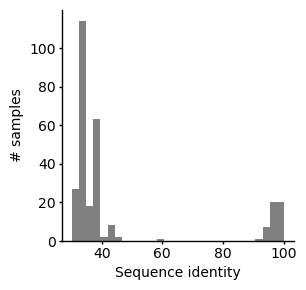

In [21]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3,3)

plt.hist(df['sequence identity'].values, bins=30, color='grey')
clean_plt(plt.gca())
plt.xlabel('Sequence identity')
plt.ylabel('# samples')
plt.savefig('figures/hist_seq_id.svg')

# Do the same for foldseek

In [22]:
reference_database = '/disk4/share/software/foldseek/structures/pdb/pdb'
foldseek_df = protein_ded_df << (FoldSeek(id_col, seq_col, reference_database, query_type='seqs',  tmp_dir='/disk1/ariane/vscode/cec_degrader/manuscript/tmp/') >> Save(f'output/DEDBase_FoldSeek.pkl'))


--------------------------------------------------------------------------------
            Running command	foldseek databases ProstT5 weights tmp	             
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------
databases ProstT5 weights tmp 

MMseqs Version:              	10.941cd33
Tsv                          	false
Force restart with latest tmp	false
Remove temporary files       	false
Compressed                   	0
Threads                      	384
Verbosity                    	3


07/15 18:01:36 [NOTICE] Downloading 1 item(s)

07/15 18:01:36 [NOTICE] CUID#7 - Redirecting to https://steineggerlab.s3.amazonaws.com/foldseek/prostt5-f16-gguf.tar.gz

07/15 18:01:36 [NOTICE] CUID#10 - Redirecting to https://steinegg

In [29]:
foldseek_df = foldseek_df.sort_values(by='fident', ascending=False)
foldseek_df = foldseek_df.drop_duplicates(subset='query')
len(foldseek_df[foldseek_df['fident'] < 0.5])

1

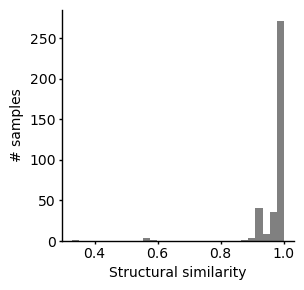

In [31]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3,3)

plt.hist(foldseek_df['fident'].values, bins=30, color='grey')
clean_plt(plt.gca())
plt.xlabel('Structural similarity')
plt.ylabel('# samples')
plt.savefig('figures/hist_structure_id.svg')

In [32]:
foldseek_df

,query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits
104949,DEDB825,1bvy-assembly1.cif.gz_F,1.000,152,0,0,480,631,1,152,1.761000e-18,949
142667,DEDB832,1bvy-assembly1.cif.gz_F,1.000,152,0,0,480,631,1,152,2.173000e-18,948
207996,DEDB1167,1bvy-assembly1.cif.gz_F,1.000,152,0,0,480,631,1,152,1.708000e-18,948
190679,DEDB778,1bvy-assembly1.cif.gz_F,1.000,152,0,0,480,631,1,152,2.549000e-18,948
85902,DEDB844,1bvy-assembly1.cif.gz_F,1.000,152,0,0,480,631,1,152,1.726000e-18,948
...,...,...,...,...,...,...,...,...,...,...,...,...
120102,DEDB1242,7ute-assembly1.cif.gz_A,0.569,190,81,0,3,191,1,190,1.839000e-13,706
33937,DEDB1240,7ute-assembly1.cif.gz_A,0.569,190,81,0,3,191,1,190,2.045000e-13,714
173692,DEDB1241,7ute-assembly1.cif.gz_A,0.564,190,82,0,3,191,1,190,1.639000e-13,699
203354,DEDB1243,7ute-assembly1.cif.gz_A,0.559,190,83,0,3,191,1,190,1.019000e-13,711
